In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

# Cek GPU
print(f"TensorFlow Version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU Terdeteksi: {gpus[0]}")
else:
    print("⚠️ Peringatan: GPU tidak terdeteksi. Training akan lambat. Pastikan Runtime Type diubah ke GPU.")

TensorFlow Version: 2.19.0
✅ GPU Terdeteksi: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
# Path file zip di Google Drive Anda
local_zip = '/content/drive/MyDrive/kupukupu/kupu.zip'
extract_path = '/content/kupu-kupu-data'

# 1. Ekstrak
if not os.path.exists(extract_path):
    print("Mengekstrak file zip...")
    zip_ref = zipfile.ZipFile(local_zip, 'r')
    zip_ref.extractall(extract_path)
    zip_ref.close()
    print("✅ Ekstraksi selesai.")
else:
    print("✅ File sudah diekstrak sebelumnya.")

# 2. Cari Lokasi CSV dan Folder Gambar
csv_path = None
train_img_dir = None

# Loop mencari file csv dan folder yang berisi gambar
for root, dirs, files in os.walk(extract_path):
    if 'Training_set.csv' in files:
        csv_path = os.path.join(root, 'Training_set.csv')

    # Asumsi folder gambar bernama 'train' atau 'train_images'
    # Jika folder anda namanya lain, script ini akan mencoba menebaknya
    if 'train' in dirs:
        train_img_dir = os.path.join(root, 'train')

if csv_path and train_img_dir:
    print(f"✅ File CSV ditemukan di: {csv_path}")
    print(f"✅ Folder Gambar ditemukan di: {train_img_dir}")
else:
    print("❌ PERHATIAN: Tidak dapat menemukan CSV atau folder 'train' secara otomatis.")
    print("Mohon cek manual path-nya.")

✅ File sudah diekstrak sebelumnya.
✅ File CSV ditemukan di: /content/kupu-kupu-data/Training_set.csv
✅ Folder Gambar ditemukan di: /content/kupu-kupu-data/train


In [17]:
import pandas as pd

# 1. Baca CSV
df = pd.read_csv(csv_path)

print(f"Jumlah data total di CSV: {len(df)}")
print("Contoh 5 baris pertama:")
print(df.head())

# Ambil nama kolom otomatis (biasanya kolom ke-0 adalah filename, ke-1 adalah label)
col_filename = df.columns[0]
col_label = df.columns[1]

# 2. Cek Ekstensi File
# Kadang di CSV cuma tertulis "kupu_01" padahal filenya "kupu_01.jpg"
sample_file = df.iloc[0][col_filename]
full_path_sample = os.path.join(train_img_dir, str(sample_file))

if not os.path.exists(full_path_sample):
    print(f"\n⚠️ File '{sample_file}' tidak ditemukan langsung.")
    print("Mencoba menambahkan ekstensi .jpg...")

    # Cek apakah pakai .jpg
    if os.path.exists(full_path_sample + ".jpg"):
        df[col_filename] = df[col_filename].astype(str) + ".jpg"
        print("✅ Berhasil! Ekstensi .jpg ditambahkan ke semua nama file di CSV.")
    # Cek apakah pakai .png
    elif os.path.exists(full_path_sample + ".png"):
        df[col_filename] = df[col_filename].astype(str) + ".png"
        print("✅ Berhasil! Ekstensi .png ditambahkan ke semua nama file di CSV.")
    else:
        print("❌ Masalah: File gambar tidak ditemukan meski sudah ditambah .jpg/.png")

# 3. Setup Generator dengan Validation Split
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # <--- Memisahkan 20% data untuk validasi
)

# Generator Training
print("\n--- Setup Data Training ---")
train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_img_dir,
    x_col=col_filename,
    y_col=col_label,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training', # Bagian Training
    shuffle=True
)

# Generator Validasi
print("\n--- Setup Data Validasi ---")
validation_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_img_dir,
    x_col=col_filename,
    y_col=col_label,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation', # Bagian Validasi
    shuffle=False
)

Jumlah data total di CSV: 6499
Contoh 5 baris pertama:
      filename                     label
0  Image_1.jpg          SOUTHERN DOGFACE
1  Image_2.jpg                    ADONIS
2  Image_3.jpg            BROWN SIPROETA
3  Image_4.jpg                   MONARCH
4  Image_5.jpg  GREEN CELLED CATTLEHEART

--- Setup Data Training ---
Found 5200 validated image filenames belonging to 75 classes.

--- Setup Data Validasi ---
Found 1299 validated image filenames belonging to 75 classes.


In [18]:
# 1. Load Base Model
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

base_model.trainable = False  # Bekukan bobot bawaan

# 2. Buat Head Model Baru
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

# Output Layer (Otomatis menyesuaikan jumlah kelas di CSV)
num_classes = len(train_generator.class_indices)
print(f"Jumlah Kelas (Spesies): {num_classes}")

outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Jumlah Kelas (Spesies): 75


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 75)             │        19,275 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,605,195 (9.94 MB)

 Trainable params: 347,211 (1.32 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [19]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [20]:
history = model.fit(
    train_generator,
    epochs=20,  # Bisa dinaikkan jika perlu
    validation_data=validation_generator,
    callbacks=[early_stop, reduce_lr]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 126s 632ms/step - accuracy: 0.1431 - loss: 3.8046 - val_accuracy: 0.6867 - val_loss: 1.4946 - learning_rate: 0.0010
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 477ms/step - accuracy: 0.5482 - loss: 1.7159 - val_accuracy: 0.7552 - val_loss: 0.9998 - learning_rate: 0.0010
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 79s 486ms/step - accuracy: 0.6573 - loss: 1.1981 - val_accuracy: 0.7983 - val_loss: 0.7680 - learning_rate: 0.0010
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 474ms/step - accuracy: 0.7175 - loss: 0.9863 - val_accuracy: 0.8168 - val_loss: 0.6732 - learning_rate: 0.0010
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 482ms/step - accuracy: 0.7593 - loss: 0.8093 - val_accuracy: 0.8383 - val_loss: 0.6129 - learning_rate: 0.0010
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 476ms/step - accuracy: 0.7746 - loss: 0.7385 - val_accuracy: 0.8368 - val_loss: 0.6037 - learning_rate: 0.0010
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 79s 485ms/step - accuracy: 0

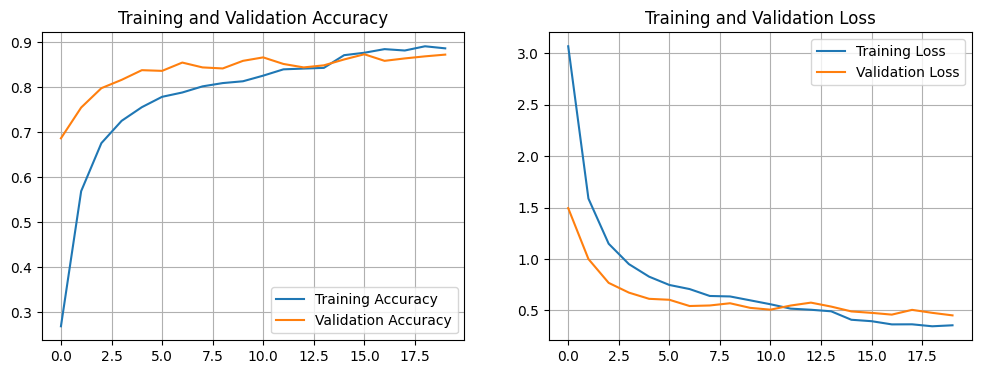

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.show()

In [25]:

model.save("/content/drive/MyDrive/kupukupu/kupukupuV2_model.h5")
print("Saved: /content/drive/MyDrive/kupukupu/kupukupu_model.h5")

Saved: /content/drive/MyDrive/kupukupu/kupukupu_model.h5


In [28]:
import pandas as pd
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Cari File CSV Test & Folder Test
test_img_dir = None
test_csv_path = None

for root, dirs, files in os.walk(extract_path):
    if 'test' in dirs:
        test_img_dir = os.path.join(root, 'test')
    if 'Testing_set.csv' in files:
        test_csv_path = os.path.join(root, 'Testing_set.csv')

# Fallback jika folder test tidak terdeteksi
if test_img_dir is None and train_img_dir is not None:
    potential = train_img_dir.replace('train', 'test')
    if os.path.exists(potential): test_img_dir = potential

if test_img_dir and test_csv_path:
    print(f"✅ Folder Test: {test_img_dir}")
    print(f"✅ File CSV Test: {test_csv_path}")

    # --- BAGIAN PERBAIKAN CSV ---
    # Coba baca normal dulu
    df_test = pd.read_csv(test_csv_path)

    # Jika terdeteksi cuma 1 kolom, coba baca ulang dengan pemisah lain
    if len(df_test.columns) < 2:
        print("⚠️ Terdeteksi hanya 1 kolom. Mencoba mendeteksi separator lain...")
        # Coba pakai titik koma
        df_temp = pd.read_csv(test_csv_path, sep=';')
        if len(df_temp.columns) >= 2:
            df_test = df_temp
            print("✅ Berhasil membaca dengan separator ';'")
        else:
            # Coba pakai tab
            df_temp = pd.read_csv(test_csv_path, sep='\t')
            if len(df_temp.columns) >= 2:
                df_test = df_temp
                print("✅ Berhasil membaca dengan separator Tab")

    print(f"\nJumlah Kolom: {len(df_test.columns)}")
    print(f"Nama Kolom: {df_test.columns.tolist()}")
    print("Contoh Data:")
    print(df_test.head(3))

    # --- LOGIKA PENENTUAN MODE ---
    col_filename = df_test.columns[0]
    has_labels = False

    if len(df_test.columns) >= 2:
        col_label = df_test.columns[1]
        has_labels = True
        print("\n✅ Label ditemukan. Mode: EVALUASI AKURASI")
    else:
        col_label = None
        has_labels = False
        print("\n⚠️ Label TIDAK ditemukan. Mode: HANYA PREDIKSI (Tanpa Skor Akurasi)")

    # Cek ekstensi file gambar
    sample_file = df_test.iloc[0][col_filename]
    full_path = os.path.join(test_img_dir, str(sample_file))
    if not os.path.exists(full_path):
        if os.path.exists(full_path + ".jpg"):
            df_test[col_filename] = df_test[col_filename].astype(str) + ".jpg"
        elif os.path.exists(full_path + ".png"):
            df_test[col_filename] = df_test[col_filename].astype(str) + ".png"

    # Setup Generator
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    # Jika punya label -> class_mode='categorical', jika tidak -> class_mode=None
    mode = 'categorical' if has_labels else None

    test_generator = test_datagen.flow_from_dataframe(
        dataframe=df_test,
        directory=test_img_dir,
        x_col=col_filename,
        y_col=col_label,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode=mode,
        shuffle=False
    )

    # --- EKSEKUSI ---
    if has_labels:
        # Jika ada label, kita bisa hitung akurasi
        print("\n--- Menghitung Akurasi ---")
        loss, accuracy = model.evaluate(test_generator)
        print(f"\n🎯 FINAL TEST ACCURACY: {accuracy*100:.2f}%")
    else:
        # Jika tidak ada label, kita cuma prediksi saja
        print("\n--- Melakukan Prediksi (Tanpa Kunci Jawaban) ---")
        preds = model.predict(test_generator)
        predicted_indices = np.argmax(preds, axis=1)
        # Mapping index ke nama label (dari data training)
        labels_map = dict((v,k) for k,v in train_generator.class_indices.items())
        predictions = [labels_map[k] for k in predicted_indices]

        # Tampilkan 5 hasil pertama
        print("\nContoh 5 Prediksi Pertama:")
        for i in range(5):
            fname = df_test.iloc[i][col_filename]
            print(f"{fname} --> Prediksi: {predictions[i]}")

else:
    print("❌ Error: Folder test atau CSV tidak ditemukan.")

✅ Folder Test: /content/kupu-kupu-data/test
✅ File CSV Test: /content/kupu-kupu-data/Testing_set.csv
⚠️ Terdeteksi hanya 1 kolom. Mencoba mendeteksi separator lain...

Jumlah Kolom: 1
Nama Kolom: ['filename']
Contoh Data:
      filename
0  Image_1.jpg
1  Image_2.jpg
2  Image_3.jpg

⚠️ Label TIDAK ditemukan. Mode: HANYA PREDIKSI (Tanpa Skor Akurasi)
Found 2786 validated image filenames.

--- Melakukan Prediksi (Tanpa Kunci Jawaban) ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 168ms/step

Contoh 5 Prediksi Pertama:
Image_1.jpg --> Prediksi: PINE WHITE
Image_2.jpg --> Prediksi: CRIMSON PATCH
Image_3.jpg --> Prediksi: ADONIS
Image_4.jpg --> Prediksi: IPHICLUS SISTER
Image_5.jpg --> Prediksi: MILBERTS TORTOISESHELL


✅ Berhasil! File 'hasil_prediksi_kupu.csv' telah disimpan.
Anda bisa mendownloadnya di menu Files di sebelah kiri.

--- Visualisasi Sampel Prediksi ---


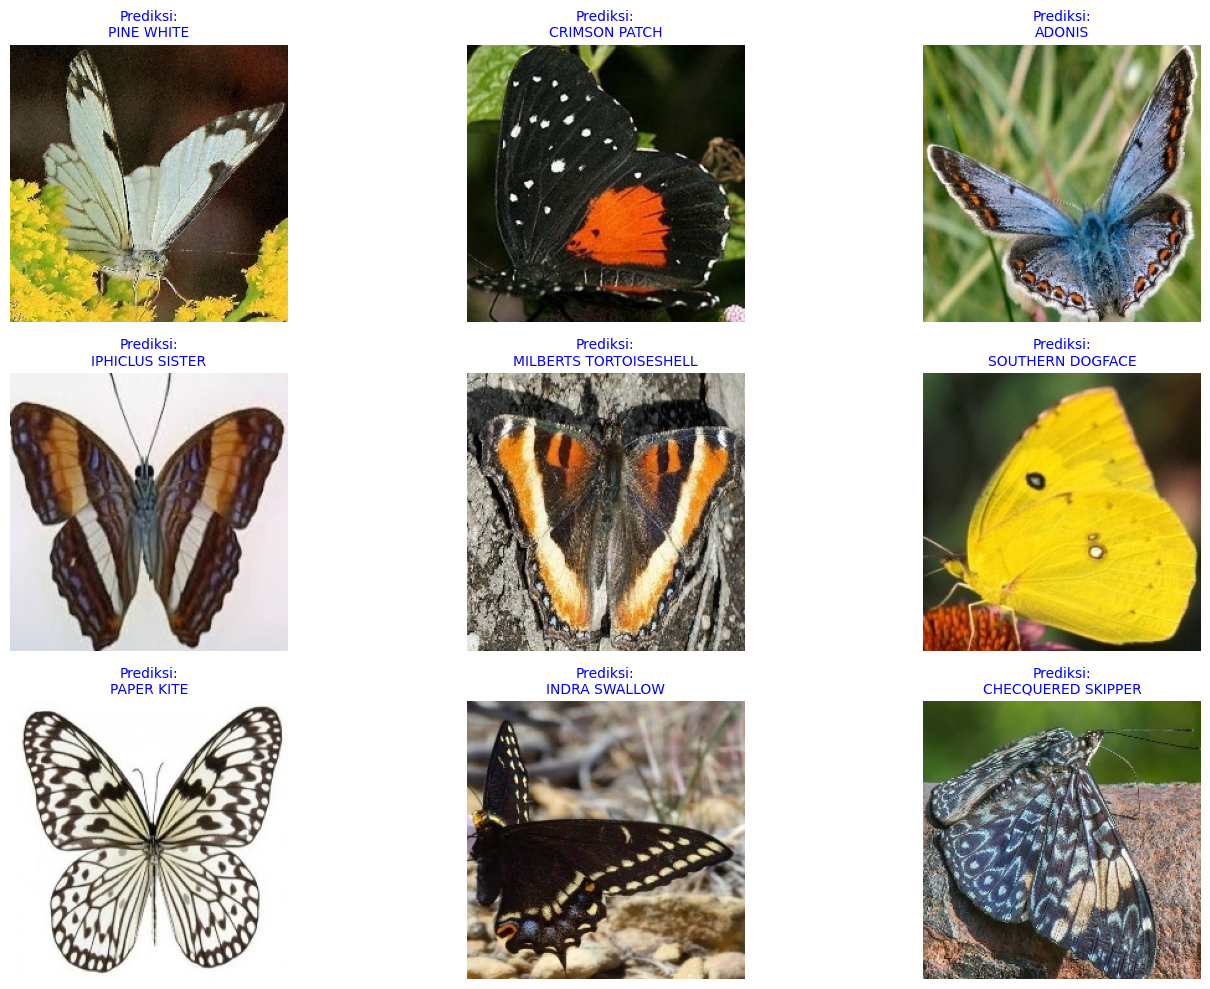

In [29]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# --- 1. SIMPAN HASIL KE CSV ---
# Membuat DataFrame baru berisi Nama File dan Prediksi Model
submission_df = pd.DataFrame({
    'filename': df_test[col_filename],
    'label': predictions  # List prediksi yang sudah dihasilkan di cell sebelumnya
})

# Simpan ke file CSV
submission_filename = 'hasil_prediksi_kupu.csv'
submission_df.to_csv(submission_filename, index=False)
print(f"✅ Berhasil! File '{submission_filename}' telah disimpan.")
print("Anda bisa mendownloadnya di menu Files di sebelah kiri.")

# --- 2. VISUALISASI CEK MANUAL (SPOT CHECK) ---
# Mari kita lihat 9 gambar pertama dan tebakan modelnya
# Apakah masuk akal? (Cek warna/pola secara visual)

print("\n--- Visualisasi Sampel Prediksi ---")
plt.figure(figsize=(15, 10))

# Kita tampilkan 9 gambar pertama
for i in range(min(9, len(df_test))):
    plt.subplot(3, 3, i + 1)

    # Ambil nama file dan prediksi
    fname = df_test.iloc[i][col_filename]
    pred_label = predictions[i]

    # Load dan tampilkan gambar
    # Pastikan path gambar benar
    img_path = os.path.join(test_img_dir, fname)

    try:
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.title(f"Prediksi:\n{pred_label}", fontsize=10, color='blue')
        plt.axis('off')
    except Exception as e:
        plt.text(0.5, 0.5, "Gambar tidak ditemukan", ha='center')
        plt.axis('off')

plt.tight_layout()
plt.show()

Silakan upload gambar kupu-kupu dari komputer Anda (jpg/png):


Saving szsczdczcz.jpg to szsczdczcz.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


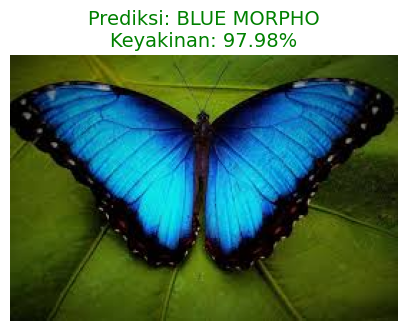

--- Detail Probabilitas untuk szsczdczcz.jpg ---
BLUE MORPHO: 97.98%
ULYSES: 1.50%
PIPEVINE SWALLOW: 0.40%




In [32]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from tensorflow.keras.preprocessing import image
import tensorflow as tf

# 1. Upload Gambar
print("Silakan upload gambar kupu-kupu dari komputer Anda (jpg/png):")
uploaded = files.upload()

# 2. Ambil Label Kelas dari Generator
# Kita balik dictionary-nya agar jadi {0: 'Adonis', 1: 'African Giant', ...}
labels_map = dict((v,k) for k,v in train_generator.class_indices.items())

# 3. Proses Setiap Gambar yang Diupload
for fn in uploaded.keys():
    path = fn

    # A. Load Gambar & Resize ke 224x224
    img = image.load_img(path, target_size=(224, 224))

    # B. Ubah ke Array & Preprocessing
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    # PENTING: Gunakan preprocess_input bawaan MobileNetV2
    # Jangan gunakan x = x / 255.0 karena model ini beda cara belajarnya
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

    # C. Prediksi
    # Mengambil probabilitas semua kelas
    preds = model.predict(x)

    # Ambil index probabilitas tertinggi
    top_prediction_index = np.argmax(preds)
    predicted_label = labels_map[top_prediction_index]
    confidence = preds[0][top_prediction_index] * 100 # Persentase keyakinan

    # D. Tampilkan Hasil
    plt.figure(figsize=(5, 5))
    plt.imshow(image.load_img(path)) # Tampilkan gambar asli
    plt.axis('off')

    # Tentukan warna judul (Hijau jika yakin > 80%, Kuning jika ragu)
    color = 'green' if confidence > 80 else 'orange'

    plt.title(f"Prediksi: {predicted_label}\nKeyakinan: {confidence:.2f}%", color=color, fontsize=14)
    plt.show()

    # E. Tampilkan Top 3 Prediksi (Opsional, biar terlihat alternatifnya)
    # Mengurutkan probabilitas dari terbesar ke terkecil
    top_3_indices = preds[0].argsort()[-3:][::-1]

    print(f"--- Detail Probabilitas untuk {fn} ---")
    for i in top_3_indices:
        print(f"{labels_map[i]}: {preds[0][i]*100:.2f}%")
    print("\n" + "="*30 + "\n")

In [33]:
# Print daftar kelas dalam format list Python agar mudah di-copy
labels = list(train_generator.class_indices.keys())
print("COPY LIST DI BAWAH INI KE FILE APP.PY ANDA NANTI:")
print("="*50)
print(labels)
print("="*50)

COPY LIST DI BAWAH INI KE FILE APP.PY ANDA NANTI:
['ADONIS', 'AFRICAN GIANT SWALLOWTAIL', 'AMERICAN SNOOT', 'AN 88', 'APPOLLO', 'ATALA', 'BANDED ORANGE HELICONIAN', 'BANDED PEACOCK', 'BECKERS WHITE', 'BLACK HAIRSTREAK', 'BLUE MORPHO', 'BLUE SPOTTED CROW', 'BROWN SIPROETA', 'CABBAGE WHITE', 'CAIRNS BIRDWING', 'CHECQUERED SKIPPER', 'CHESTNUT', 'CLEOPATRA', 'CLODIUS PARNASSIAN', 'CLOUDED SULPHUR', 'COMMON BANDED AWL', 'COMMON WOOD-NYMPH', 'COPPER TAIL', 'CRECENT', 'CRIMSON PATCH', 'DANAID EGGFLY', 'EASTERN COMA', 'EASTERN DAPPLE WHITE', 'EASTERN PINE ELFIN', 'ELBOWED PIERROT', 'GOLD BANDED', 'GREAT EGGFLY', 'GREAT JAY', 'GREEN CELLED CATTLEHEART', 'GREY HAIRSTREAK', 'INDRA SWALLOW', 'IPHICLUS SISTER', 'JULIA', 'LARGE MARBLE', 'MALACHITE', 'MANGROVE SKIPPER', 'MESTRA', 'METALMARK', 'MILBERTS TORTOISESHELL', 'MONARCH', 'MOURNING CLOAK', 'ORANGE OAKLEAF', 'ORANGE TIP', 'ORCHARD SWALLOW', 'PAINTED LADY', 'PAPER KITE', 'PEACOCK', 'PINE WHITE', 'PIPEVINE SWALLOW', 'POPINJAY', 'PURPLE HAIRSTREAK